In [1]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split

# Данные

In [5]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
print('Train:{}   Test:{}'.format(train.shape,test.shape))

Train:(1460, 80)   Test:(1459, 79)


In [6]:
y_train = train['SalePrice']
train = train.drop(['SalePrice'], axis=1)

## Разберемся с выбросами в данных

### Числовые признаки

In [7]:
numerical_columns = []
categorical_columns = []
for column in train.columns:
    if train[column].dtype in ['int64', 'float64'] and column != "SalePrice":
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

print(f"numerical: {len(numerical_columns)}")
print(f"categorical: {len(categorical_columns)}")

numerical: 36
categorical: 43


In [8]:
def DetectNaNs(df):
    missing_features = df[numerical_columns].columns[df[numerical_columns].isnull().any()]
    num_features = len(missing_features)
    if num_features == 0:
        print("No NANs")
        return
    n_cols = 2
    n_rows = (num_features + n_cols - 1) // n_cols  # Рассчитываем количество строк
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
    axes = axes.flatten()
    for i in range(len(axes)):
        if i >= num_features:
            axes[i].axis('off')

    for i, column in enumerate(missing_features):
        axes[i].hist(df[column].dropna(), bins=20, color='blue', alpha=0.7)
        axes[i].set_title(f'{column} ({df[column].isnull().sum()} пропусков)')

    plt.tight_layout()
    plt.show()

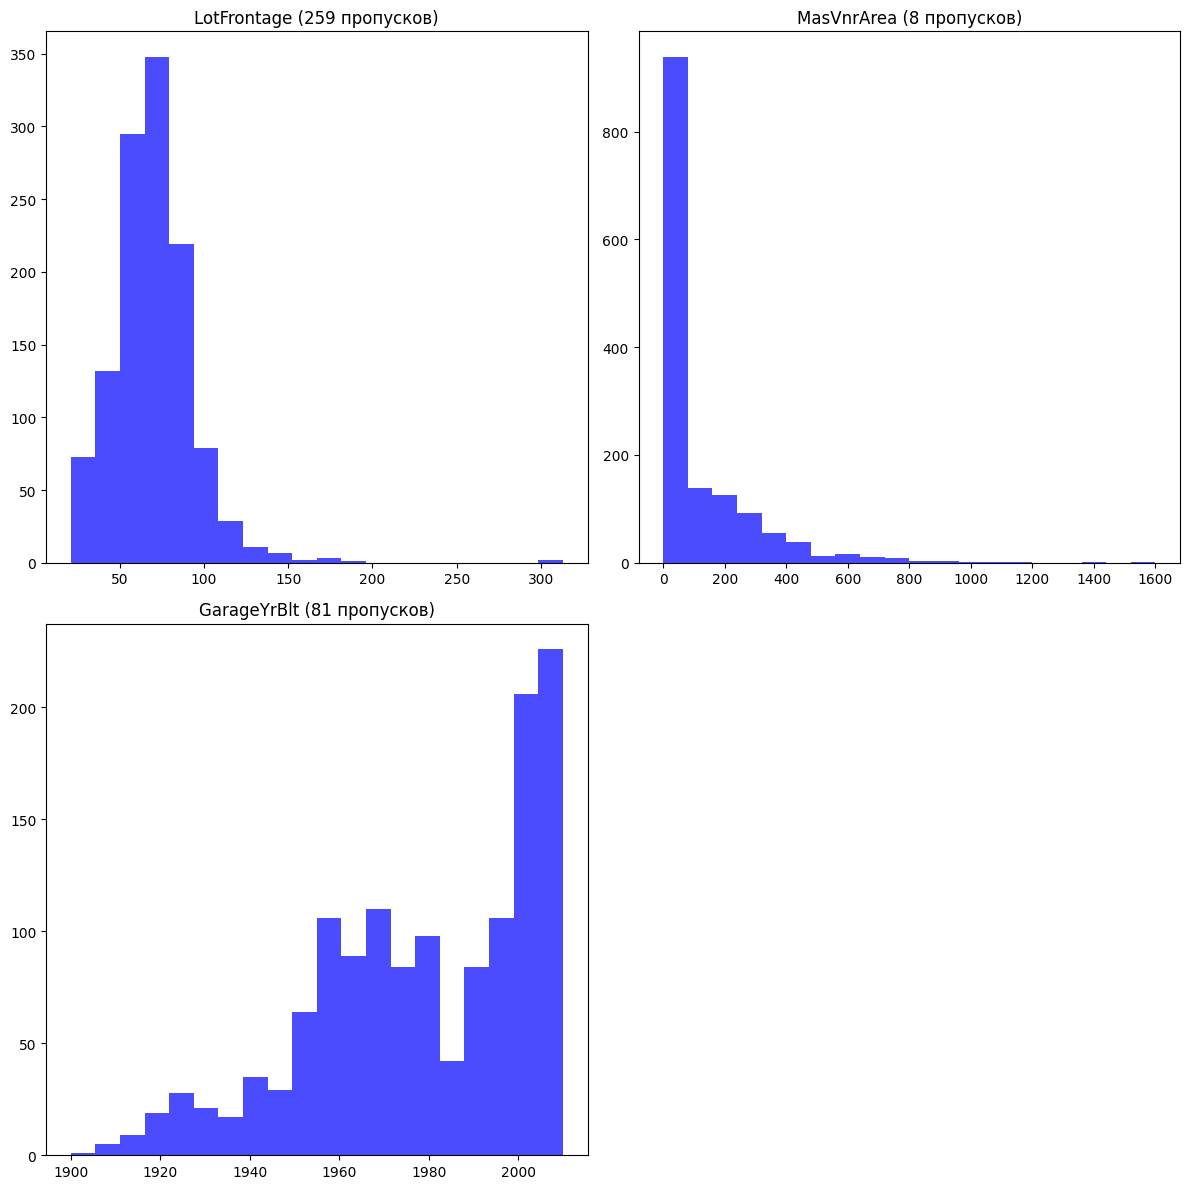

In [9]:
DetectNaNs(train)

* #### Видим что столбцы: LotFrontage - имеют распределение близкое к нормальному. Давайте в них пропуски заменим на медиану.

* #### Заметим также что в признаке MasVnrArea - распределение сильно локализовано вблизи одного значения. Заполним там значение на наиболее популярное

* #### Остался столбец GarageYrBlt. Распределение немного похоже на нормальное. Заполним медианами.

In [10]:
for column in ['LotFrontage', 'GarageYrBlt']:
    train_median = train[column].median()
    train[column] = train[column].fillna(train_median)

for column in ['MasVnrArea']:
    train[column] = train[column].fillna(train[column].mode()[0])

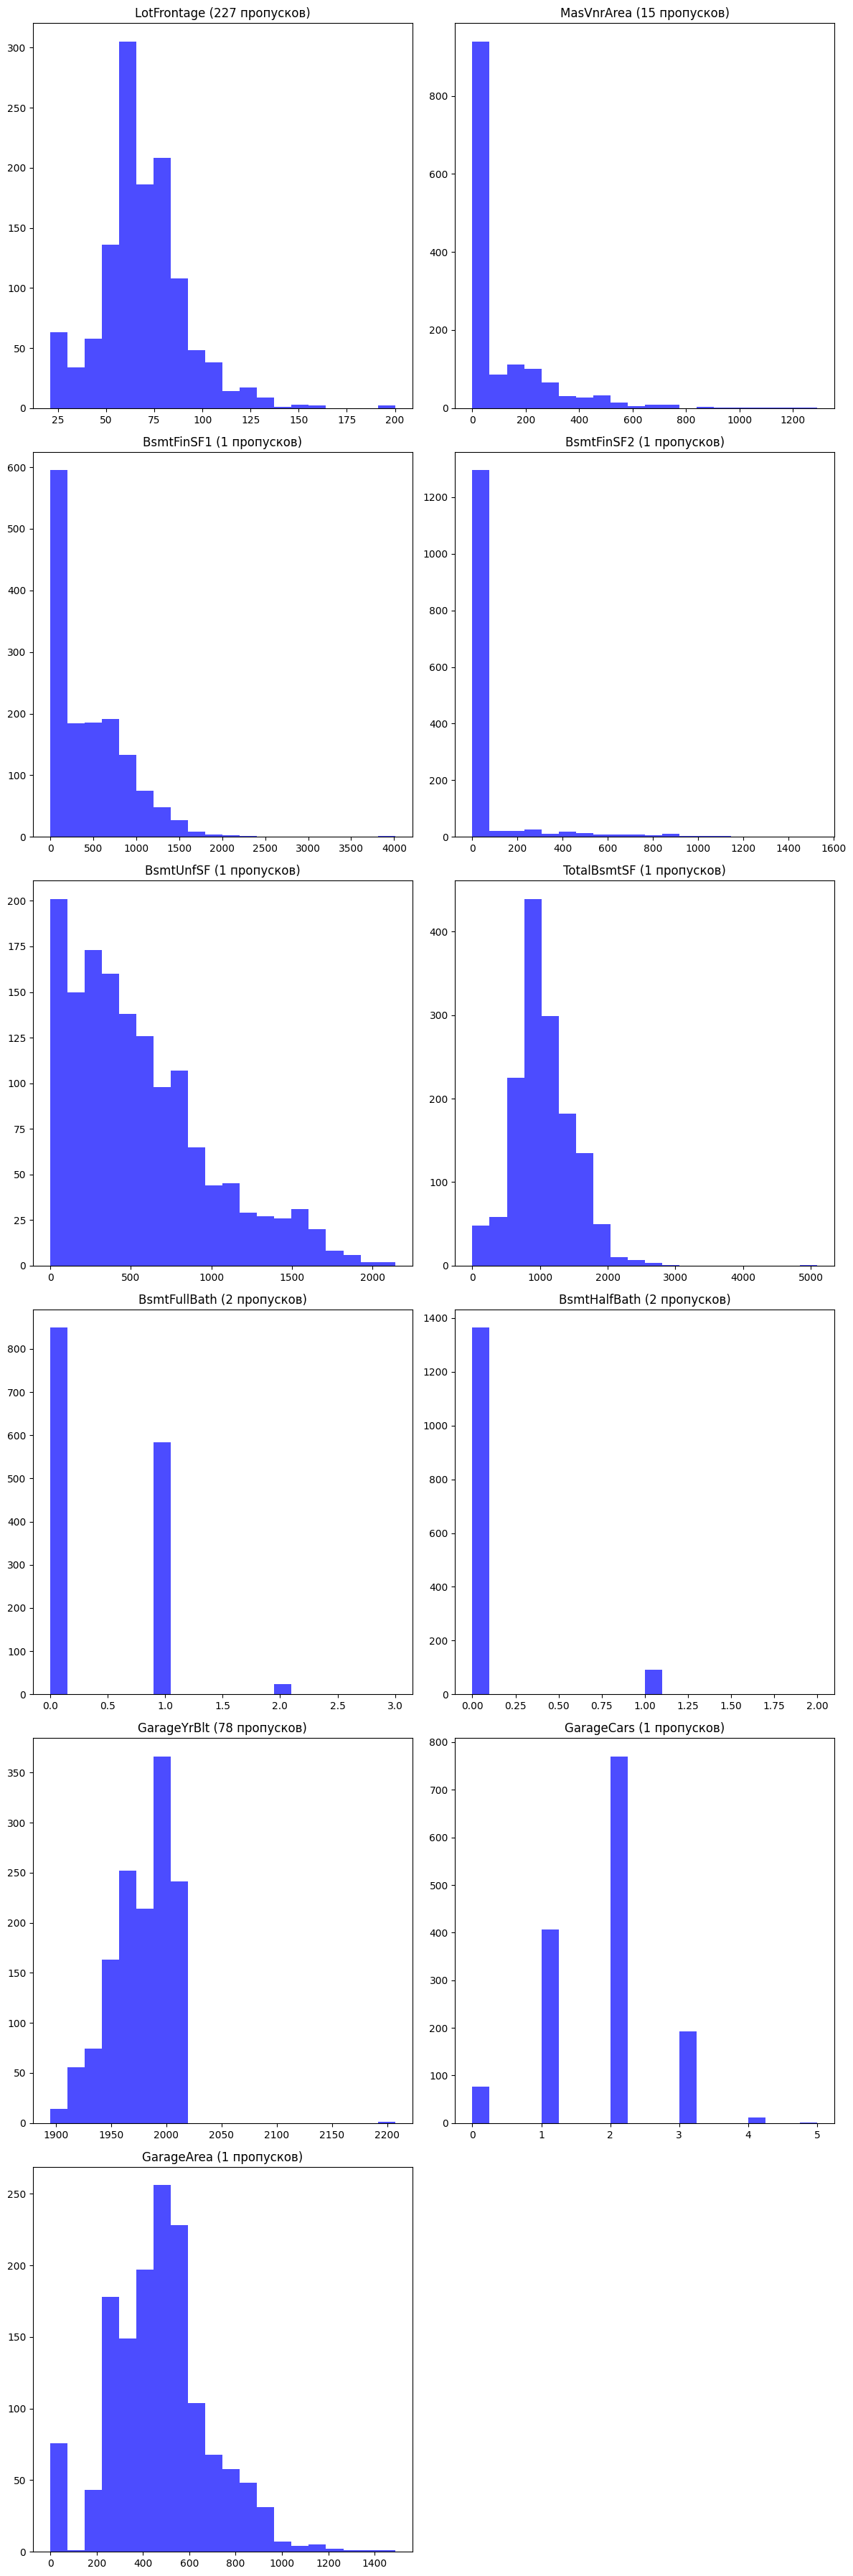

In [11]:
DetectNaNs(test)

In [12]:
for column in ['LotFrontage', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'GarageYrBlt']:
    test_median = test[column].median()
    test[column] = test[column].fillna(test_median)

for column in ['MasVnrArea']:
    test[column] = test[column].fillna(test[column].mode()[0])

### Категориальные фичи

In [13]:
# Посмотрим сколько признаков имеют пропуски в данных

for column in categorical_columns:
    null_count = train[column].isnull().sum()
    if (null_count != 0):
        print(f"В колонке {column} имеется {null_count} пропусков")

В колонке Alley имеется 1369 пропусков
В колонке MasVnrType имеется 872 пропусков
В колонке BsmtQual имеется 37 пропусков
В колонке BsmtCond имеется 37 пропусков
В колонке BsmtExposure имеется 38 пропусков
В колонке BsmtFinType1 имеется 37 пропусков
В колонке BsmtFinType2 имеется 38 пропусков
В колонке Electrical имеется 1 пропусков
В колонке FireplaceQu имеется 690 пропусков
В колонке GarageType имеется 81 пропусков
В колонке GarageFinish имеется 81 пропусков
В колонке GarageQual имеется 81 пропусков
В колонке GarageCond имеется 81 пропусков
В колонке PoolQC имеется 1453 пропусков
В колонке Fence имеется 1179 пропусков
В колонке MiscFeature имеется 1406 пропусков


Преобразуем категориальные фичи к строковому типу и заполним пропуски значением "No"

In [14]:
categorical_features = [
    feature for feature, dtype in train.dtypes.items() if dtype == object
]

train[categorical_features] = train[categorical_features].fillna("NO")
test[categorical_features] = test[categorical_features].fillna("NO")

In [15]:
len(categorical_features)

43

Рассмотрим распределение SalePrice

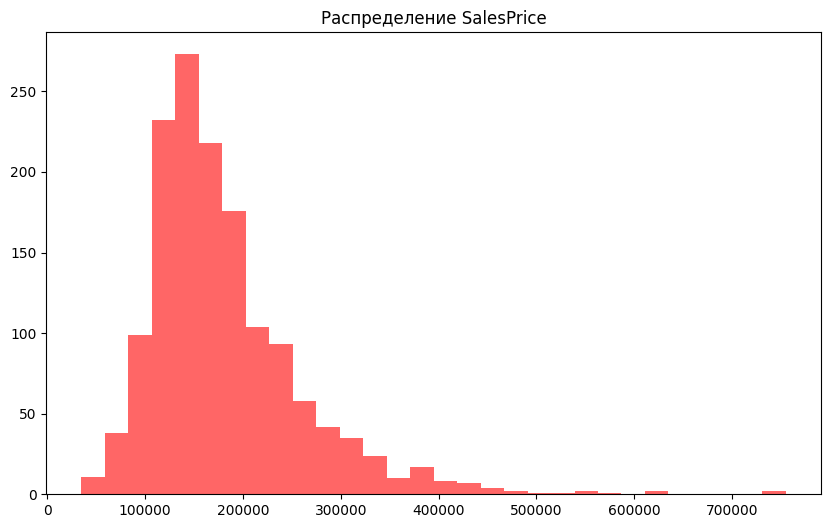

In [16]:
plt.figure(figsize = (10, 6))

plt.hist(y_train, bins=30, alpha=0.6, color='r')
plt.title("Распределение SalesPrice")
plt.show()

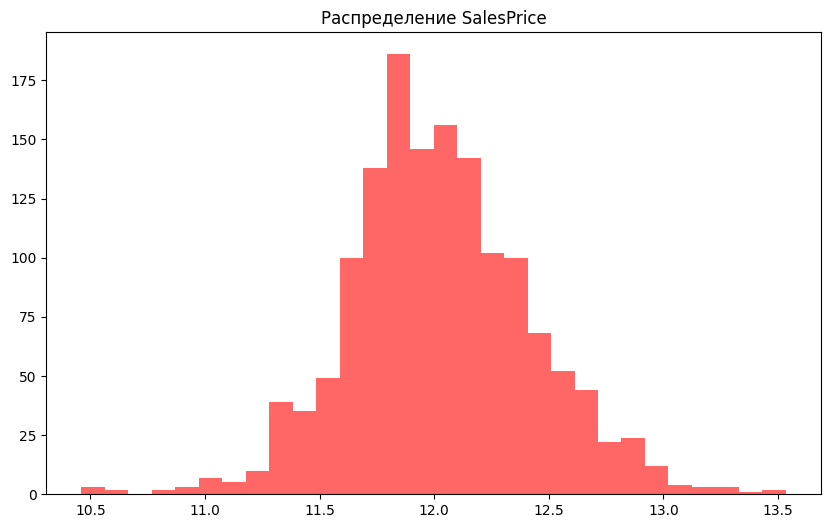

In [17]:
# Переведем в логарифмический масштаб

y_train = np.log(y_train)
plt.figure(figsize = (10, 6))

plt.hist(y_train, bins=30, alpha=0.6, color='r')
plt.title("Распределение SalesPrice")
plt.show()

In [18]:
def handle_outliers_iqr(df, columns, strategy='clip'):
    """
    Обрабатывает выбросы в указанных столбцах методом межквартильного размаха (IQR).

    :param df: DataFrame, в котором обрабатываются выбросы.
    :param columns: Список столбцов для обработки выбросов.
    :param strategy: Стратегия обработки ('remove' для удаления, 'clip' для обрезки).
    :return: DataFrame с обработанными выбросами.
    """
    for col in columns:
        # Рассчитываем квартили и межквартильный размах
        Q1 = df[col].quantile(0.25)  # Первый квартиль (25%)
        Q3 = df[col].quantile(0.75)  # Третий квартиль (75%)
        IQR = Q3 - Q1  # Межквартильный размах

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if strategy == 'remove':
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif strategy == 'clip':
            df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

columns_to_check = numerical_columns
train = handle_outliers_iqr(train, columns_to_check, strategy='clip')

print(train.describe())

        MSSubClass  LotFrontage       LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     55.085616    69.090411   9647.388014     6.100685     5.543493   
std      37.508183    17.231909   3594.356399     1.378430     0.963696   
min      20.000000    31.500000   1481.500000     2.000000     3.500000   
25%      20.000000    60.000000   7553.500000     5.000000     5.000000   
50%      50.000000    69.000000   9478.500000     6.000000     5.000000   
75%      70.000000    79.000000  11601.500000     7.000000     6.000000   
max     145.000000   107.500000  17673.500000    10.000000     7.500000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000      1460.0  ...   
mean   1971.299315   1984.865753    89.406336   439.997517         0.0  ...   
std      30.108397     20.645407   134.017553   433.219435         0.0  ...   
min    1

## Модели

### Baseline

In [19]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Словарь для хранения моделей
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor()
}

for name, model in models.items():
    model.fit(train[numerical_columns], y_train)
    y_pred = np.exp(model.predict(test[numerical_columns]))
    submission_df = {"Id": test.index, "SalePrice": y_pred}
    solution = pd.DataFrame(submission_df)
    solution.to_csv(f"baseline_{name}_submission.csv", index=False)

### Catboost

In [20]:
pool = Pool(train, y_train, cat_features=categorical_features)

base_catboost = CatBoostRegressor(random_seed=312)
base_catboost.fit(pool, verbose=False)

In [21]:
y_pred = base_catboost.predict(test)
submission_df = {"Id": test.index, "SalePrice": np.exp(y_pred)}
solution = pd.DataFrame(submission_df)
solution.to_csv(f"Base_Catboost_submission.csv", index=False)

Получили результат: 0.1246 (RMSE)

### Давайте попробуем улучшить эту модель

### Давайте создадим пару новых признаков
* HouseAge - возраст дома на момент продажи
* RemodAge - время прошедшее на момент ремонта
* SaleSeason - сезон продажи
* TotalSF - Общая жилая площадь
* TotalArea - Общая площадь с гаражом
* TotalOutdoorSF - Общая площадь открытых зон
* LivingAreaRatio - Коэффициент жилой площади к участку
* OverallScore - Общее качество дома
* RoomsPerArea - Число комнат на жилую площадь
* BedroomsToBathrooms - Число спален на ванные комнаты
* NeighborhoodAvgPrice - Средняя цена в районе
* PriceDeviationNeighborhood - Отклонение от средней цены района

In [22]:
train_with_sale_price = pd.read_csv("train.csv", index_col=0)

In [23]:
def AddNewFeatures(data):
  data = data.copy()
  data['HouseAge'] = data['YrSold'] - data['YearBuilt']
  data.drop(["HouseAge"], axis=1, inplace=True)

  data['LivingAreaRatio'] = data['GrLivArea'] / data['LotArea']

  neighborhood_avg_price_dict = train_with_sale_price.groupby('Neighborhood')['SalePrice'].mean().to_dict()
  data['NeighborhoodAvgPrice'] = data['Neighborhood'].map(neighborhood_avg_price_dict)

  categorical_features = [
    feature for feature, dtype in data.dtypes.items() if dtype == object
  ]

  data[categorical_features] = data[categorical_features].fillna("NO")

  return data, categorical_features

In [24]:
new_train, categorical_features = AddNewFeatures(train)
new_test, _ = AddNewFeatures(test)
pool = Pool(new_train, y_train, cat_features=categorical_features)
test_pool = Pool(new_test, cat_features=categorical_features)
new_features_catboost = CatBoostRegressor(random_seed=312)
new_features_catboost.fit(pool, verbose=False)

predictions = new_features_catboost.predict(test_pool)
submission_df = {"Id": test.index, "SalePrice": np.exp(predictions)}
solution = pd.DataFrame(submission_df)
solution.to_csv(f"new_features_catboost_submission.csv", index=False)

Получили результат: 0.12198

In [26]:
params = {
    'iterations': 3000,
    'depth': 8,
    'l2_leaf_reg': 0.004142371694868208,
    'random_seed': 312,
    'loss_function': "MAPE"
}
new_features_catboost_optuned = CatBoostRegressor(**params)
new_features_catboost_optuned.fit(pool, verbose=False)

predictions = new_features_catboost.predict(test_pool)
submission_df = {"Id": test.index, "SalePrice": np.exp(predictions)}
solution = pd.DataFrame(submission_df)
solution.to_csv(f"new_features_catboost_optuned_submission.csv", index=False)

Результат не изменился.